<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.851 · Tipología y ciclo de vida de los datos · PRA2</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA2: Limpieza y análisis de datos

<div class="alert alert-block alert-info">
    <strong>Autores:</strong>
        <div>Enrique Callejas Castro</div>
        <div>Germán del Cacho Salvador</div>
</div>

El objetivo de esta actividad será el tratamiento de un dataset. En concreto, realizaremos un preprocesado y un análisis de datos del *dataset* [*tidy_dc_airbnb.csv*](https://www.kaggle.com/code/dehaozhang/stacking-ensemble/data?select=tidy_dc_airbnb.csv) (Kaggle, 2020).

## ÍNDICE:
1. [Descripción del dataset](#uno)
2. [Integración y selección de los datos de interés a analizar](#dos)
3. [Limpieza de los datos](#tres)
4. [Análisis de los datos](#cuatro)
6. [Resolución del problema](#cinco)
8. [Referencias y contribuciones](#seis)

## 1. Descripción del dataset  <a class="anchor" id="uno"></a>

En los últimos años, los alojamientos turísticos de particulares se han popularizado. La expansión de plataformas como Airbnb han tenido un impacto importante en la sociedad, por lo que resulta fundamental desarrollar nuevas herramientas que permitan comprender este nuevo mercado.

El presente proyecto tiene como objetivo el preprocesado y un primer análisis de un conjunto de datos de la plataforma Airbnb, referente a alojamientos situados en Washington DC. Nos hemos propuesto **localizar los barrios más caros y más baratos**, **conocer cuáles son las variables que más impactan en el precio del alojamiento** y desarrollar un modelo que permita **predecir el precio** de un nuevo alojamiento. 

In [1]:
# Importamos las librerías necesarias

# Preprocesado
import numpy as np
import pandas as pd
import json
from shapely.geometry import shape, Point

# Visualización
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import geopandas as gpd
import folium

# Análisis
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

In [2]:
# Cargamos los datos en un dataframe
df = pd.read_csv('data/tidy_dc_airbnb.csv')

In [3]:
print('El dataset cuenta con un total de {} columnas y de {} filas'
      .format(df.shape[1], df.shape[0]))

El dataset cuenta con un total de 19 columnas y de 3671 filas


In [4]:
display(df.head())

Unnamed: 0 host_response_rate host_acceptance_rate  host_listings_count  \
0           1                92%                  91%                   26   
1           2                90%                 100%                    1   
2           3                90%                 100%                    2   
3           4               100%                  NaN                    1   
4           5                92%                  67%                    1   

   accommodates        room_type  bedrooms  bathrooms  beds    price  \
0             4  Entire home/apt         1        1.0     2  $160.00   
1             6  Entire home/apt         3        3.0     3  $350.00   
2             1     Private room         1        2.0     1   $50.00   
3             2     Private room         1        1.0     1   $95.00   
4             4  Entire home/apt         1        1.0     1   $50.00   

   minimum_nights  maximum_nights  number_of_reviews   latitude  longitude  \
0               1            1125                  0  38.890046 -77.002808   
1               2              30                 65  38.880413 -76.990485   
2               2            1125                  1  38.955291 -76.986006   
3               1            1125                  0  38.872134 -77.019639   
4               7            1125                  0  38.996382 -77.041541   

            city zipcode state  tidy_price  
0     Washington   20003    DC         160  
1     Washington   20003    DC         350  
2    Hyattsville   20782    MD          50  
3     Washington   20024    DC          95  
4  Silver Spring   20910    MD          50

La primera exploración del archivo elegido (tidy_dc_airbnb.csv) nos permite ver que cuenta con un total de 3671 filas y 19 columnas. Después de una primera exploración, se ha identificado el significado de cada columna:

- *Unnamed: 0*: identificador del registro
- *host_response_rate*: tasa de respuesta del anfitrión (en %)
- *host_acceptance_rate*: tasa de aceptación del anfitrión (en %)
- *host_listings_count*: número de huéspedes alojados
- *accommodates*: capacidad del alojamiento
- *room_type*: tipo de habitación (apartamento entero/habitación privada/habitación compartida)
- *bedrooms*: número de habitaciones
- *bathrooms*: número de baños
- *beds*: número de camas
- *price*: precio por noche (en dólares)
- *minimum_nights*: número mínimo de noches
- *maximum_nights*: número máximo de noches
- *number_of_reviews*: número mínimo de opiniones
- *latitude*: latitud
- *longitude*: longitud
- *city*: ciudad
- *zipcode*: código postal
- *state*: estado
- *tidy_price*: precio por noche (en dólares)

## 2. Integración y selección de los datos de interés a analizar  <a class="anchor" id="dos"></a>

Para realizar los análisis es necesario realizar las siguientes **transformaciones preliminares**:

- *Unnamed: 0*: **renombrar** la columna como "id".
- *host_response_rate* y *host_acceptance_rate*: eliminar signo de porcentaje para **convertir** la variable a tipo *float*.
- *price*: eliminar signo de dolar y **convertir** a *float*.
- *latitude* y *longitude*: **fundir** las columnas para crear una sola con una tupla que represente las coordenadas.
- *city*: **filtrar** los registros de la ciudad de Washington, en la que centraremos el análisis
- *zipcode*, *state* y *tidy_price*: **eliminar** estas columnas.

In [5]:
# Realizamos las transformaciones indicadas en cada columna
df = df.rename(columns={"Unnamed: 0": "id"})
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('float')
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype('float')
df['price'] = df['price'].str.replace(',','',regex=True).str.replace('$','',regex=True).astype(float)
df['coordenates'] = list(zip(df['longitude'],df['latitude']))
df = df[df['city'].str.contains('Washington')]
df = df.drop(['zipcode', 'state', 'tidy_price'], axis=1)

Además, **enriqueceremos el dataset con una nueva columna *neighborhood***. Esta columna contendrá el barrio en el que se ubica la vivienda. Para ello, utilizaremos un geojson que contiene las coordenadas de los barrios de la ciudad de Washington. Dicho geojson puede descargarse en la siguiente dirección:
https://opendata.dc.gov/datasets/neighborhood-clusters/explore?location=38.381222%2C-77.277478%2C8.82

In [6]:
# Definimos una función que devuelve el barrio de Washington DC en el que se encuentra una coordenada
def get_nbh(point, js):
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return(feature["properties"]["NBH_NAMES"])

# Cargamos el geojson
with open('data/Neighborhood_Clusters.geojson') as f:
    js = json.load(f)
    

# Comprobamos a qué barrio pertenece cada vivienda
neighborhood = []
for point in df.coordenates:
    point = Point(point[0], point[1])
    neighborhood.append(get_nbh(point, js))
    
# Añadimos una nueva columna al dataframe
df["neighborhood"] = neighborhood

Conociendo las coordenadas de cada vivienda podemos visualizar el conjunto de viviendas en el mapa de la ciudad y, de este modo, **detectar visualmente los barrios caros y baratos**. Para ello, hemos pasado los precios a escala logarítmica, que refleja mejor la naturaleza dicotómica de la clasificación. El objetivo de este gráfico es generar una nueva columna *expensive_neighborhood* a partir de la información visual que identifiquemos. La idoneidad de dicha columna será contrastada en el ejercicio 4.

In [7]:
gdf = gpd.read_file('data/Neighborhood_Clusters.geojson')
gdf_houses = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf_houses["price_log"] = np.log10(gdf_houses["price"])
m = gdf.explore(tooltip="NBH_NAMES", color="white")
gdf_houses.explore(m=m,
                   tooltip="neighborhood",
                   column="price_log",
                   color="price_log",
                   cmap="seismic",
                   legend=False,
                   marker_kwds=dict(radius=1, fill=True))

folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
display(m)

Como vemos en el gráfico, hay algunos barrios que presentan una **alta concentración de puntos rojos** (podemos pasar el ratón por encima del barrio o de la vivienda para identificar el barrio), como:
* Capitol Hill, Lincoln Park
* Georgetown, Burleith/Hillandale
* West End, Foggy Bottom, GWU
* Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street

Estos serán los barrios que identifiquemos como caros, para lo que creremos una nueva variable.

In [8]:
expensive_nbh = ['Capitol Hill, Lincoln Park',
                 'Georgetown, Burleith/Hillandale',
                 'West End, Foggy Bottom, GWU',
                 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street']
df['expensive_nbh'] = df.neighborhood.apply(lambda x: 1 if x in expensive_nbh else 0)

Por último **eliminamos las columnas empleadas para obtener la variable *expensive_nbh***:

In [9]:
# Eliminamos columnas innecesarias
df = df.drop(columns=['latitude',
                      'longitude',
                      'coordenates',
                      'city',
                      'coordenates',
                      'id',
                      'neighborhood',
                      'geometry',
                      'price_log'], axis=1)

Mostramos en pantalla la dimensión final del dataset y los primeros registros:

In [10]:
print('El dataset cuenta con un total de columnas {} y de {} filas'
      .format(df.shape[1],df.shape[0]))

El dataset cuenta con un total de columnas 13 y de 3644 filas


In [11]:
display(df.head())

host_response_rate  host_acceptance_rate  host_listings_count  \
0                92.0                  91.0                   26   
1                90.0                 100.0                    1   
3               100.0                   NaN                    1   
5               100.0                 100.0                    1   
6               100.0                   NaN                    1   

   accommodates        room_type  bedrooms  bathrooms  beds  price  \
0             4  Entire home/apt         1        1.0     2  160.0   
1             6  Entire home/apt         3        3.0     3  350.0   
3             2     Private room         1        1.0     1   95.0   
5             4  Entire home/apt         2        1.0     4   99.0   
6             4  Entire home/apt         2        2.0     2  100.0   

   minimum_nights  maximum_nights  number_of_reviews  expensive_nbh  
0               1            1125                  0              1  
1               2              30                 65              1  
3               1            1125                  0              0  
5               1            1125                  0              0  
6               3            1125                  0              0

## 3. Limpieza de los datos  <a class="anchor" id="tres"></a>

### 3.1. Elementos nulos

Consultamos los elementos nulos y vemos que únicamente tienen valores perdidos las variables *host_acceptance_rate* (16.30%) y *host_response_rate* (11.47%). En este caso, no consideramos los valores igual a 0 como nulos ya que pueden tener un significado en la realidad; como apartamentos que no han recibido ninguna valoración, apartamentos que no tienen cama porque tienen otra alternativa (e.g., sofá), etc.

La imputación de valores perdidos es un tema controvertido ya que no hay una única recomendación sobre el porcentage máximo a partir del cuál no se deben imputar valores perdidos. No obstante, existe cierto consenso en que se puede realizar la imputación si éstos no representan más del 20% de los registros. En este caso, por tanto, imputaremos los valores en ambas variables siguiendo el método kNN. No obstante, realizaremos dicha transformación tras tratar los valores atípicos y extremos.

In [12]:
# Consulta de elementos nulos (expresado en porcentaje)
display(pd.DataFrame(df.isnull().sum() / len(df)*100).rename({0:"Nulos"}, axis=1))

Nulos
host_response_rate    11.470911
host_acceptance_rate  16.300768
host_listings_count    0.000000
accommodates           0.000000
room_type              0.000000
bedrooms               0.000000
bathrooms              0.000000
beds                   0.000000
price                  0.000000
minimum_nights         0.000000
maximum_nights         0.000000
number_of_reviews      0.000000
expensive_nbh          0.000000

### 3.2. Valores atípicos y valores extremos

Para detectar los valores atípicos aplicamos la función *describe* mediante la cual podemos ver los principales estatísticos descriptivos de las variables cuantitativas. Esta función es muy útil ya que nos permite identificar posibles errores como porcentajes superiores a 100 o precios negativos.

In [13]:
# Exploración de las distribuciones de las variables cuantitativas
display(df.describe())

host_response_rate  host_acceptance_rate  host_listings_count  \
count         3226.000000           3050.000000          3644.000000   
mean            91.400806             86.376393            12.899286   
std             14.886035             21.264548            62.394902   
min              7.000000              0.000000             1.000000   
25%             90.000000             79.000000             1.000000   
50%            100.000000             98.000000             1.000000   
75%            100.000000            100.000000             3.000000   
max            100.000000            100.000000           480.000000   

       accommodates     bedrooms    bathrooms         beds        price  \
count   3644.000000  3644.000000  3644.000000  3644.000000  3644.000000   
mean       3.197859     1.209111     1.258095     1.648738   149.148463   
std        2.006053     0.841332     0.587408     1.186481   137.864318   
min        1.000000     0.000000     0.000000     1.000000    10.000000   
25%        2.000000     1.000000     1.000000     1.000000    85.000000   
50%        2.000000     1.000000     1.000000     1.000000   115.000000   
75%        4.000000     1.000000     1.000000     2.000000   165.000000   
max       16.000000    10.000000     8.000000    16.000000  2822.000000   

       minimum_nights  maximum_nights  number_of_reviews  expensive_nbh  
count     3644.000000    3.644000e+03        3644.000000     3644.00000  
mean         2.233260    5.928732e+05          15.170692        0.19978  
std          3.623274    3.557498e+07          29.307778        0.39989  
min          1.000000    1.000000e+00           0.000000        0.00000  
25%          1.000000    1.097500e+02           1.000000        0.00000  
50%          2.000000    1.125000e+03           4.000000        0.00000  
75%          3.000000    1.125000e+03          16.000000        0.00000  
max        180.000000    2.147484e+09         362.000000        1.00000

En la exploración, observamos anomalías en las siguientes variables:

- *maximum_nights*: valor medio de 35,574,980.51 y máximo de 2,147,483,647.00

Visualizamos también las frecuencias en la variable categórica *room type*, para ver si hay algún valor que sea necesario integrar (por ejemplo dos cadenas aludiendo a un mismo concepto):

In [14]:
# Exploración de las distribuciones de la variable categórica
display(pd.DataFrame(df['room_type'].value_counts()))

room_type
Entire home/apt       2366
Private room          1183
Shared room             95

No observamos ningún valor atípico ni transformación necesaria.

Respecto del resto de variables, aunque puedan presentar *outliers*, estas (posibles) anomalías podrían representar valores, si bien extremos, reales. No obstante, siguiendo una de las recomendaciones más extendidas, consideraremos *outliers* a eliminar **aquellos registros que se alejen más de tres desviaciones típicas de la media en las variables: *price*, *minimum_nights*, *maximum_nights* y *number_of_reviews***. 

**Nota**: Nótese que, mediante la operación de borrado, se eliminan las anomalías ya identificadas en la columna *maximum_nights*. 

In [15]:
# Tratamiento de los valores atípicos y extremos
cols = ['price','minimum_nights',
        'maximum_nights','number_of_reviews']

def del_outliers(df, cols, std=3):
    for c in cols:
        lim_inf = df[c].mean()-3*df[c].std()
        lim_sup = df[c].mean()+3*df[c].std()
        df = df[df[c].between(lim_inf, lim_sup)]
        return df
    
df = del_outliers(df, cols)

Mostramos el número de registros resultantes tras todas las transformaciones:

In [16]:
print('El dataset cuenta con un total de columnas {} y de {} filas'
      .format(df.shape[1],df.shape[0]))

El dataset cuenta con un total de columnas 13 y de 3584 filas


Ahora ya podemos **imputar los valores perdidos** mediante el método de los *k* vecinos más cercanos:

In [17]:
# Imputación de valores perdidos
imputer = KNNImputer()
df_knn = df.drop(['room_type'], axis=1)

df_knn = pd.DataFrame(imputer.fit_transform(df_knn))

df['host_response_rate'] = df_knn[0].tolist()
df['host_acceptance_rate'] = df_knn[1].tolist()

In [18]:
display(pd.DataFrame(df.isnull().sum()).rename({0:"Nulos"}, axis=1))

Nulos
host_response_rate        0
host_acceptance_rate      0
host_listings_count       0
accommodates              0
room_type                 0
bedrooms                  0
bathrooms                 0
beds                      0
price                     0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
expensive_nbh             0

## 4. Análisis de los datos  <a class="anchor" id="cuatro"></a>

### 4.1. Selección de los grupos de datos

En el segundo apartado de la actividad, hemos visualizado la distribución de viviendas por barrios de la ciudad de Washington y hemos identificado visualmente aquellos barrios que, aparentemente, contenían precios por noche más altos. Hemos denominado *barrios caros* a dichos barrios, y hemos añadido esta información a nuestro dataset. No obstante, es muy conveniente comprobar si la identificación realizada es o no correcta y si, por lo tanto, podemos afirmar que los precios son, por norma general, más altos en los barrios que hemos identificado como caros. Para ello, primero **separaremos los precios en dos conjuntos: precios de barrios baratos y precios de barrios caros**. 

In [19]:
precios_barrios_baratos = df[df.expensive_nbh==0].price
precios_barrios_caros = df[df.expensive_nbh==1].price

### 4.2. Comprobación de la normalidad y homogeneidad de la varianza
En función del contraste de hipótesis que deseemos efectuar, utilizaremos uno u otro estadístico de contraste (*t test*, *Welch t test*, prueba chi cuadrado...). Algunas de estas pruebas son paramétricas, por lo que conviene conocer la distribución de los datos y si puede asumirse que las muestras a comparar comparten o no la misma varianza.

Comenzamos visualizando los **gráficos QQ** de cada muestra:

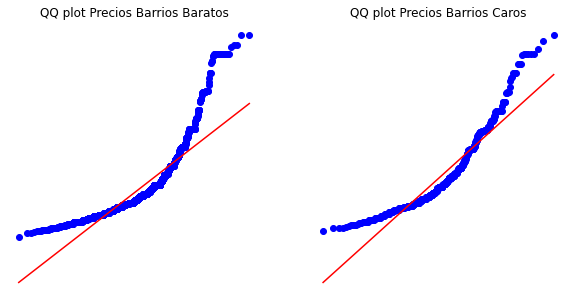

In [20]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
stats.probplot(precios_barrios_baratos, dist="norm", plot=axes[0])
axes[0].axis('off')
axes[0].set_title("QQ plot Precios Barrios Baratos")
stats.probplot(precios_barrios_caros, dist="norm", plot=axes[1])
axes[1].axis('off')
axes[1].set_title("QQ plot Precios Barrios Caros")
plt.show()

Como vemos, **no parece en absoluto que los datos estén distribuidos normalmente**. En cualquier caso, realizaremos el **test de Shapiro-Wilk**: 

In [21]:
def is_normal(v):
    stat, p = stats.shapiro(v)
    print("Estadístico: {}\nP valor:{}".format(round(stat, 2), round(p, 2)))
    if p > 0.05:
        print("Probablemente normal")
    else:
        print("Probablemente no normal")


print("Distribución precios barrios baratos:")
is_normal(precios_barrios_baratos)

print("\nDistribución precios barrios caros:")
is_normal(precios_barrios_caros)

Distribución precios barrios baratos:
Estadístico: 0.8
P valor:0.0
Probablemente no normal

Distribución precios barrios caros:
Estadístico: 0.88
P valor:0.0
Probablemente no normal


Habida cuenta de los resultados, concluimos que **los datos no se distribuyen normalmente**. Para determinar la homocedasticidad o heterocedasticidad de los datos utilizaremos el **test de Levene**: 

In [22]:
def same_variance(x1, x2):
    stat, p = stats.levene(x1, x2)
    print("Estadístico: {}\nP valor:{}".format(round(stat, 2), round(p, 2)))
    if p > 0.05:
        print("Probablemente misma varianza")
    else:
        print("Probablemente distinta varianza")
        
same_variance(precios_barrios_baratos, precios_barrios_caros)

Estadístico: 51.0
P valor:0.0
Probablemente distinta varianza


Del test anterior inferimos que los datos tienen **distinta varianza**. 

### 4.3. Aplicación de pruebas estadísticas

#### 4.3.1 ¿Es realmente más alto el precio/noche en los barrios que hemos identificado como caros?

Nos interesa determinar si el precio medio por noche en los barrios que creemos que son caros es realmente superior al precio medio por noche en los barrios que hemos identificado como baratos. La **hipótesis nula** es **el precio medio por noche es igual en los barrios identificados como baratos que en los identificados como caros**, mientras que la hipótesis alternativa es **el precio medio por noche es inferior en los barrios identificados como baratos que en los identificados como caros**. Tenemos, por lo tanto, el siguiente contraste de hipótesis:

$H_0 = \mu_{baratos} = \mu_{caros}$

$H_1 = \mu_{baratos} < \mu_{caros}$

Tenemos, por lo tanto, que contrastar las medias de **dos muestras que no se distribuyen normalmente y que no comparten la misma varianza**. Ahora bien, respecto de la primera consideración (distribución no normal), quizás podamos aplicar el teorema del límite central en caso de que contemos con un número suficientemente alto de observaciones. Comprobemos, pues, este extremo:

In [23]:
print("Observaciones barrios baratos: {}".format(len(precios_barrios_baratos)))
print("Observaciones barrios caros: {}".format(len(precios_barrios_caros)))

Observaciones barrios baratos: 2879
Observaciones barrios caros: 705


En los dos casos tenemos un elevado número de observaciones, en cualquier caso más de treinta, por lo que podemos aplicar el **teorema del límite central**, según el cual la distribución de las **medias muestrales** de una población se distribuye normalmente cuando tenemos un número lo suficientemente elevado de observaciones (más de treinta, en la práctica). Dicha distribución de las medias muestrales tiene **media igual a la poblacional** y **desviación típica $\sigma/\sqrt(n)$**.

Por lo tanto, en virtud de este teorema, tenemos dos distribuciones normales (las distribuciones de las medias muestrales de cada conjunto de precios) con media $\mu_{baratos}$ y $\mu_{caros}$; y con desviación típica $\sigma_{baratos}/\sqrt(n_{baratos})$ y  $\sigma_{caros}/\sqrt(n_{caros})$, respectivamente.

En consecuencia, podemos aplicar la **prueba *t test de Welch***, una prueba no paramética que se utiliza para determinar si dos conjuntos de datos que se distribuyen normalmente tienen distinta media. A diferencia de la prueba *t* tradicional, la variante de Welch no asume la homocedasticidad de los datos, por lo que podemos aplicarlo perfectamente.


In [24]:
def welch_test(x1, x2, alt):
    stat, p = stats.ttest_ind(x1, x2, equal_var = False, alternative=alt)
    print("Estadístico: {}\nP valor:{}".format(round(stat, 2), round(p, 2)))
    if p > 0.05:
        print("Se acepta la hipótesis nula")
    else:
        print("Se rechaza la hipótesis nula")
        
welch_test(precios_barrios_baratos, precios_barrios_caros, "less")

Estadístico: -11.93
P valor:0.0
Se rechaza la hipótesis nula


Para la prueba *t de Welch* hemos obtenido un p valor de 0, por lo que para cualquier nivel de significancia **podemos rechazar la hipótesis nula**, lo que implica que, efectivamente, **el precio medio es mayor en los barrios que hemos identificado visualmente como caros**, por lo que la introducción de la variable *expensive_nbh* está plenamente justificada. 

#### 4.3.2 Correlación lineal las variables independientes y la variable respuesta

Para determinar qué variables predictoras están más fuertemente correlacionadas con la variable respuesta, podemos calcular el **coeficiente de correlación lineal de pearson** entre cada predictor y la respuesta. 

In [25]:
# Separamos la variable respuesta de las variables predictoras
X = df.drop(['price'],axis=1)
y = df['price']

# Aplicamos one hot encoding a las variables categóricas
X = pd.get_dummies(data=X, columns=['room_type'])

In [26]:
display(pd.DataFrame(X.apply(lambda x: x.corr(y, method="pearson"))).rename({0: "Coef Pearson"}, axis=1).sort_values(
    by="Coef Pearson", key=abs, ascending=False))

Coef Pearson
accommodates                   0.586298
bedrooms                       0.569235
beds                           0.486227
bathrooms                      0.485796
room_type_Entire home/apt      0.436862
room_type_Private room        -0.397048
host_listings_count            0.243117
expensive_nbh                  0.219341
room_type_Shared room         -0.140928
number_of_reviews             -0.075510
host_acceptance_rate          -0.065567
host_response_rate            -0.030606
maximum_nights                 0.028090
minimum_nights                 0.025945

Vemos que, según el coeficiente de correlación de Pearson, **las variables más relacionadas con el precio son la capacidad del alojamiento, el número de huéspedes, el número de habitaciones, el número de camas, el número de baños, el tipo de alojamiento (vivienda, habitación...) y el tipo de barrio (caro o barato)**. Podemos graficar la correlación lineal entre las variables numéricas, ordinales o continuas, y la variable respuesta mediante **diagramas de puntos**:

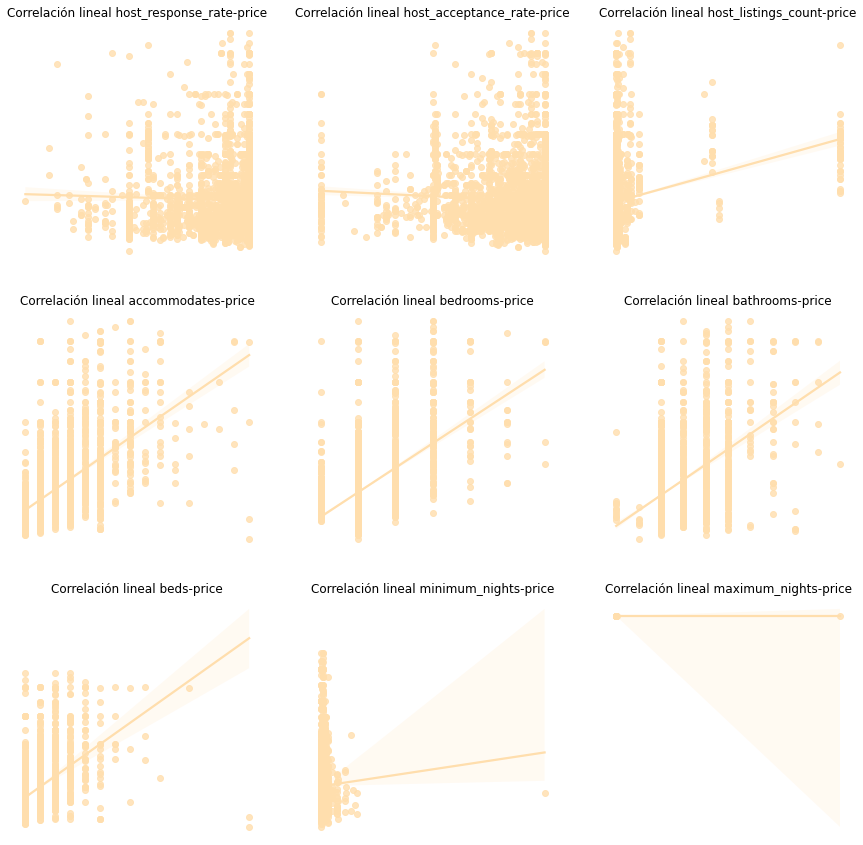

In [27]:
fig, axes = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
cols = df.drop(["price", "room_type", "expensive_nbh"], axis=1).columns

v = 0
for i in list(range(0, 3)):
    for j in list(range(0, 3)):
        var = cols[v]
        sns.regplot(x=var, y="price", data=df, color='navajowhite',
            ax=axes[i,j]).set(title='Correlación lineal {}-price'.format(var))
        v+=1
        axes[i, j].axis('off')
plt.show()

Asimismo, y con el fin de detectar la **colinealidad**, en caso de haberla, calculamos la correlación lineal entre las variables numéricas predictoras, para lo que generamos una matriz de correlación:

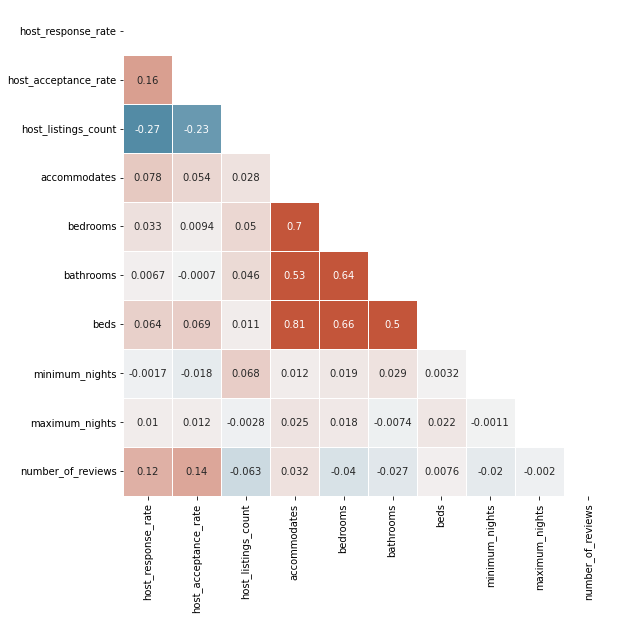

In [28]:
corr = df.drop(["price", "room_type", "expensive_nbh"], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, cbar=False,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

Vemos que la variable *accommodates* está fuertemente correlacionada con *beds*. Dado que dicha correlación es superior a 0.8, podemos **eliminar una de las dos variables** antes de implementar la regresión lineal múltiple. Dado que *accommodates* está más correlacionada con *price* que *beds*, eliminamos esta última.

In [29]:
X = X.drop("beds", axis=1)

#### 4.3.3 Regresión lineal múltiple

Por último, definiremos a partir de los datos un **modelo de regresión lineal múltiple** que nos permita predecir futuros precios por noche. 

In [30]:
reg = LinearRegression().fit(X, y)
print("El coeficiente de determinación del modelo es: {}".format(round(reg.score(X, y), 2)))

El coeficiente de determinación del modelo es: 0.54


El **coeficiente de determinación** es de **0.54**, lo que implica que el modelo solo explica algo más de la mitad del 50% de la varianza de los datos. Si solo atendemos a este indicador, podemos concluir que **el modelo es moderadamente predictivo**, aunque también podríamos optar por otras métricas quizás más esclarecedoras, como el error estándar del modelo.

In [31]:
# Aislamos y mostramos los coeficientes del hiperplano
intercept = round(reg.intercept_, 2)
coefs = dict(zip(X.columns, np.round_(reg.coef_, 1)))

In [32]:
print("El valor del intercepto es: {}".format(intercept))
print("El valor de los coeficientes es: {}".format(coefs))

El valor del intercepto es: 22.63
El valor de los coeficientes es: {'host_response_rate': 0.0, 'host_acceptance_rate': -0.1, 'host_listings_count': 0.2, 'accommodates': 8.3, 'bedrooms': 28.4, 'bathrooms': 27.8, 'minimum_nights': -0.5, 'maximum_nights': 0.0, 'number_of_reviews': -0.1, 'expensive_nbh': 28.9, 'room_type_Entire home/apt': 37.0, 'room_type_Private room': -5.2, 'room_type_Shared room': -31.8}


Por lo tanto, **demos estimar el precio por noche a partir del siguiente modelo**

$\hat{y} = 22.78 + 0x_{resp rate} - 0.1x_{accept rate} + 0.2x_{list count} + 9.3x_{accom} + 28.9x_{bedrooms} + 28x_{bathrooms} - 0.5x_{minnights} - 0x_{maxnights} -0.1x_{revisions} +28.9x_{expensivenbh} + 36.5x_{entire} -5.7x_{privaterrom} -30.8x_{privateroom}$

Finalmente, **exportamos el dataframe resultante** en un nuevo csv:

In [34]:
df.to_csv("data/airbnb_final.csv")

## 5. Resolución del problema  <a class="anchor" id="cinco"></a>

A partir de los resultados obtenidos, podemos extraer las siguientes **conclusiones**:
* Hay **barrios o zonas de Washington DC donde el alojamiento en Airbnb es significativamente más caro** que en otros. Estos barrios son céntricos y están a orillas del río Potomac. Son Capitol Hill, Lincoln Park, Georgetown, Burleith/Hillandale, West End, Foggy Bottom, GWU, Downtown, Chinatown, Penn Quarters, Mount Vernon Square y North Capitol Street.
* El precio por noche del alojamiento queda fundamentalmente determinado por la **capacidad del alojamiento**, el número de **huéspedes**, de **habitaciones**, **camas y baños** de la vivienda; así como por el **tipo** de alojamiento (más caro en apartamento, más barato en habitación, privada o compartida) y por el **barrio**.
* Mediante una regresión lineal múltiple **se ha podido generar un modelo de predicción de precios que representa algo más de la mitad de la varianza de los datos**. Si atendemos exclusivamente al coeficiente de determinación, el modelo, aunque moderadamente predictivo, no es muy bueno. Puede haber dos motivos: o bien las variables independientes no son lo suficientemente predictivas o bien la relación entre la variable respuesta y las variables predictoras debería estimarse a partir de un modelo no lineal.
    

## 6. Referencias y contribuciones <a class="anchor" id="seis"></a>

- Calvo M., Subirats L., Pérez D. (2019). *Introducción a la limpieza y análisis de los datos*. Editorial UOC.
- Megan Squire (2015). *Clean Data*. Packt Publishing Ltd.
- Jiawei Han, Micheine Kamber, Jian Pei (2012). *Data mining: concepts and techniques*. Morgan Kaufmann.
- Jason W. Osborne (2010). Data Cleaning Basics: Best Practices in Dealing with Extreme Scores. *Newborn and Infant Nursing Reviews; 10* (1): pp. 1527-3369.
- Kaggle (2020). *tidy_dc_airbnb*. Recuperado de https://www.kaggle.com/code/dehaozhang/stacking-ensemble/data?select=tidy_dc_airbnb.csv
- Peter Dalgaard (2008). *Introductory statistics with R*. Springer Science & Business Media.
- Wes McKinney (2012). *Python for Data Analysis*. O’Reilley Media, Inc.

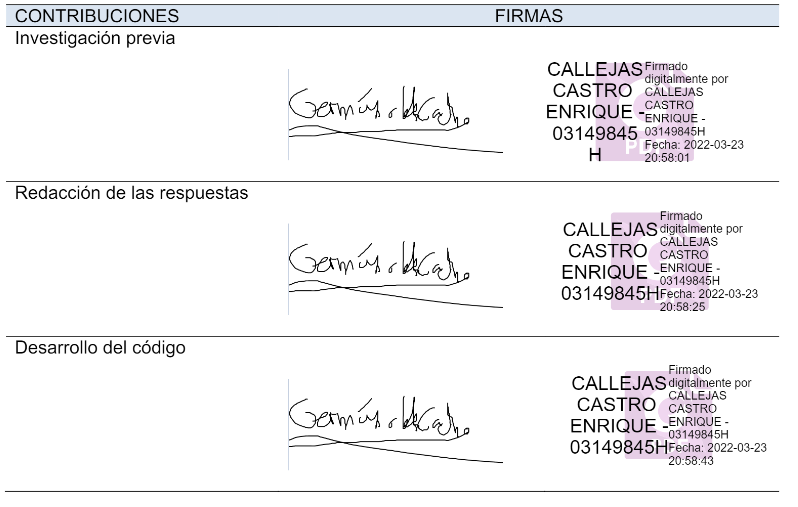